In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading and Visualizing the Data.

In [2]:
year_3_df = pd.read_csv('DGS3.csv', date_parser=['DATE'])
year_5_df = pd.read_csv('DGS5.csv', date_parser=['DATE'])

df = pd.merge(year_3_df, year_5_df)

In [3]:
# Converts object to 

def convert_df(series):
    return pd.to_numeric(series, errors='coerce')

In [4]:
df['DGS3'] = convert_df(df['DGS3'])
df['DGS5'] = convert_df(df['DGS5'])
df['DATE'] = pd.to_datetime(df['DATE'])

df.set_index('DATE', inplace=True)

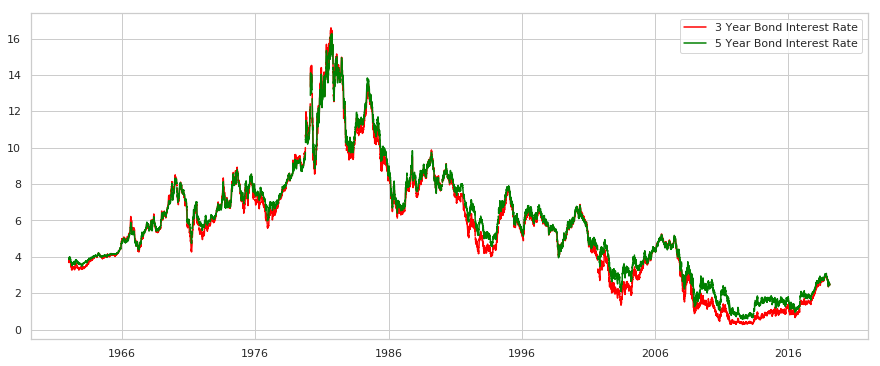

In [5]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))

plt.plot(df['DGS3'], color='red', label='3 Year Bond Interest Rate')
plt.plot(df['DGS5'], color='green', label='5 Year Bond Interest Rate')
plt.legend()

# Calculating the interest difference

In [6]:
df['DIFF'] = df['DGS5'] - df['DGS3']

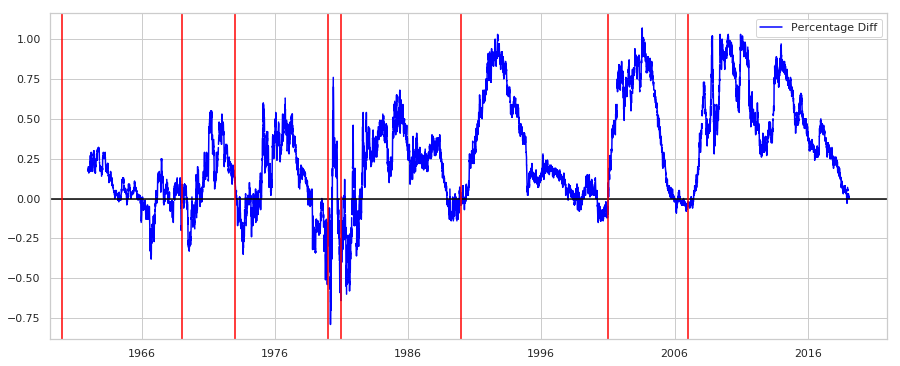

In [7]:
import datetime as dt

sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
plt.plot(df['DIFF'], color='blue', label='Percentage Diff')
plt.legend()

plt.axhline(0, color='black')

years = [1960, 1969, 1973, 1980, 1981, 1990, 2001, 2007]

for year in years:
    plt.axvline(dt.datetime(year, 1, 1), color='red')


In [8]:
df.head()

,DGS3,DGS5,DIFF
DATE,,,
1962-01-02,3.70,3.88,0.18
1962-01-03,3.70,3.87,0.17
1962-01-04,3.69,3.86,0.17
1962-01-05,3.71,3.89,0.18
1962-01-08,3.71,3.91,0.20


# Time Series Forecasting

1. Naive approach - With mean squared error
2. Simple Average
3. Moving Average - Average of the past few days.
4. Weighted Moving Average
5. Simple Exponential Smoothing
6. Holt Linear Trend
7. Holts Winter Method

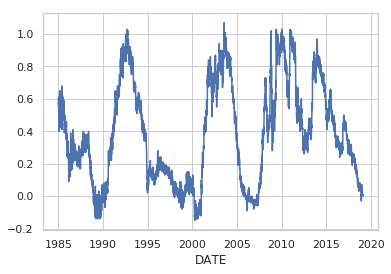

In [30]:
df = df.fillna(method='ffill')
df[df.index > '1985'].DIFF.plot()
df = df[df.index > '1985']

In [31]:
train = df[:'2010']
val = df['2010':]

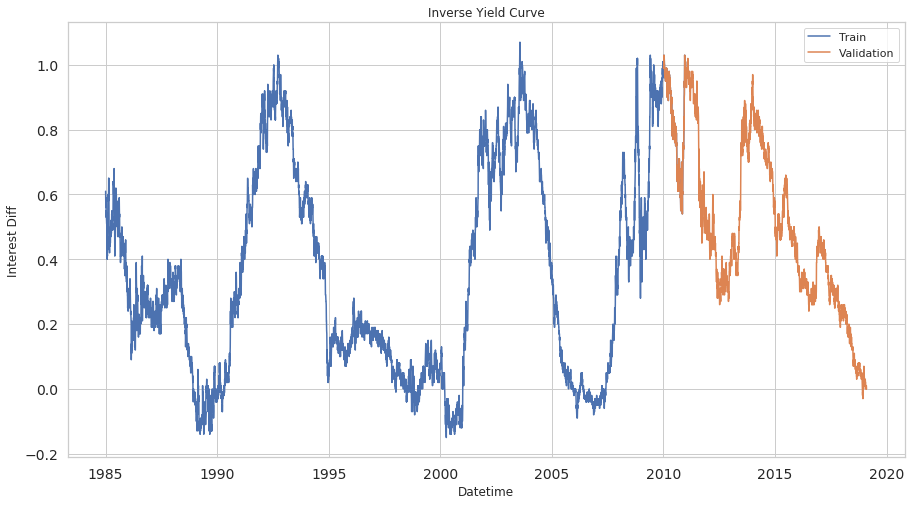

In [32]:
train.DIFF.plot(figsize=(15, 8), title='Inverse Yield Curve', fontsize=14, label='Train')
val.DIFF.plot(figsize=(15, 8), title='Inverse Yield Curve', fontsize=14, label='Validation')
plt.xlabel('Datetime')
plt.ylabel('Interest Diff')
plt.legend(loc = 'best')

## Naive Method

Text(0.5,1,'Naive Forecast')

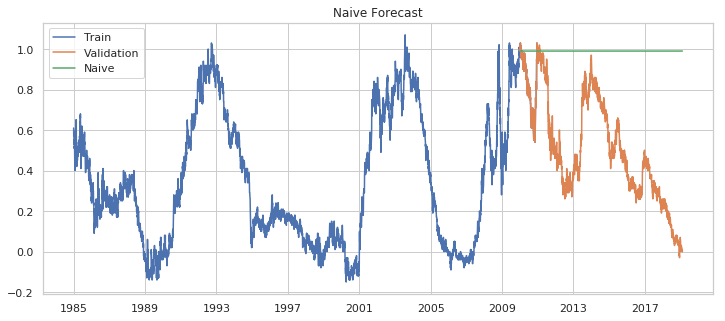

In [33]:
dd = np.asanyarray(train.DIFF)
y_hat = val.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize = (12,5))
plt.plot(train.index, train['DIFF'],label = 'Train')
plt.plot(val.index, val['DIFF'], label = 'Validation')
plt.plot(y_hat.index, y_hat['naive'],  label = 'Naive')
plt.legend(loc = 'best')
plt.title('Naive Forecast')

In [34]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(val.DIFF, y_hat.naive))
rmse

0.5462824409251662

# Holts Linear Trend